In [2]:
%cd ..

/home/jayant/Projects/recurse/hn_analyze


In [3]:
import os
import pandas as pd
import numpy as np
import cufflinks as cf
import matplotlib.pyplot as plt
from newspaper import Article

import logging
logging.basicConfig(level=logging.INFO)

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
DATA_DIR = 'data/'
RAW_ARTICLES_DIR = os.path.join(DATA_DIR, 'articles', 'raw')
PARSED_ARTICLES_DIR = os.path.join(DATA_DIR, 'articles', 'parsed')
CORPUS_DIR = os.path.join(DATA_DIR, 'corpora')
TEST_ARTICLES_DIR = os.path.join(DATA_DIR, 'articles', 'test')

In [6]:
hn_df = pd.read_csv('./data/HN_posts_year_to_Sep_26_2016.csv')

In [7]:
hn_df.head()

,id,title,url,num_points,num_comments,author,created_at
0,12579008,You have two days to comment if you want stem ...,http://www.regulations.gov/document?D=FDA-2015...,1,0,altstar,9/26/2016 3:26
1,12579005,SQLAR the SQLite Archiver,https://www.sqlite.org/sqlar/doc/trunk/README.md,1,0,blacksqr,9/26/2016 3:24
2,12578997,What if we just printed a flatscreen televisio...,https://medium.com/vanmoof/our-secrets-out-f21...,1,0,pavel_lishin,9/26/2016 3:19
3,12578989,algorithmic music,http://cacm.acm.org/magazines/2011/7/109891-al...,1,0,poindontcare,9/26/2016 3:16
4,12578979,How the Data Vault Enables the Next-Gen Data W...,https://www.talend.com/blog/2016/05/12/talend-...,1,0,markgainor1,9/26/2016 3:14


In [10]:
hn_df.describe()

,id,num_points,num_comments
count,2.931190e+05,293119.000000,293119.000000
mean,1.133046e+07,15.025324,6.525544
std,6.961055e+05,58.504103,30.376319
min,1.017690e+07,1.000000,0.000000
25%,1.071636e+07,1.000000,0.000000
50%,1.130303e+07,2.000000,0.000000
75%,1.193152e+07,4.000000,1.000000
max,1.257901e+07,5771.000000,2531.000000


(array([  2.93119000e+05,   5.32450000e+04,   3.81990000e+04,
          3.25220000e+04,   2.92930000e+04,   2.72070000e+04,
          2.50880000e+04,   2.31770000e+04,   2.14190000e+04,
          2.01380000e+04,   1.86550000e+04,   1.72680000e+04,
          1.60590000e+04,   1.49450000e+04,   1.41120000e+04,
          1.32140000e+04,   1.23730000e+04,   1.15400000e+04,
          1.09520000e+04,   1.03070000e+04,   9.70700000e+03,
          9.11500000e+03,   8.68600000e+03,   8.17100000e+03,
          7.69100000e+03,   7.26100000e+03,   6.86200000e+03,
          6.51800000e+03,   6.16300000e+03,   5.84100000e+03,
          5.51600000e+03,   5.26800000e+03,   5.00700000e+03,
          4.77800000e+03,   4.55200000e+03,   4.37000000e+03,
          4.18600000e+03,   4.02100000e+03,   3.82700000e+03,
          3.64300000e+03,   3.52200000e+03,   3.38900000e+03,
          3.23200000e+03,   3.09200000e+03,   2.98800000e+03,
          2.85400000e+03,   2.73600000e+03,   2.64000000e+03,
        

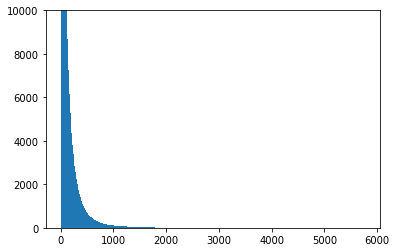

In [11]:
plt.ylim(ymax = 10000)
plt.hist(hn_df['num_points'], bins=1000, cumulative=-1)

In [8]:
min_points_threshold = 50  # Remove all posts with points less than threshold to eliminate noise
hn_df_trimmed = hn_df[hn_df['num_points'] > 50]

In [9]:
hn_df_trimmed = hn_df_trimmed[pd.notnull(hn_df_trimmed['url'])]  # Remove posts without valid urls

In [10]:
print(hn_df_trimmed.count())
hn_df_trimmed.head(10)

id              20148
title           20148
url             20148
num_points      20148
num_comments    20148
author          20148
created_at      20148
dtype: int64


,id,title,url,num_points,num_comments,author,created_at
63,12578100,Adobe and Berkeley's new deep learning image e...,https://github.com/junyanz/iGAN,52,8,visionp,9/25/2016 23:44
67,12578028,Appropriate Uses for SQLite,https://sqlite.org/whentouse.html,125,56,ftclausen,9/25/2016 23:27
87,12577792,Smart pointers and move semantics in modern C++,https://www.oreilly.com/ideas/2-major-reasons-...,55,40,severine,9/25/2016 22:27
88,12577787,UnGoogled Chromium: Chromium with enhanced pri...,https://github.com/Eloston/ungoogled-chromium,251,120,kawera,9/25/2016 22:26
96,12577685,What I Learned from a Stroke at 26: Make Time ...,http://www.nytimes.com/2016/09/25/jobs/what-i-...,81,28,allsystemsgo,9/25/2016 21:58
99,12577652,Chelsea Manning's 14 days in solitary for suic...,https://www.amnesty.org.uk/press-releases/chel...,53,34,robin_reala,9/25/2016 21:51
103,12577629,The Fundamental Limits of Machine Learning,http://nautil.us/blog/the-fundamental-limits-o...,56,11,dnetesn,9/25/2016 21:47
111,12577497,Marc Andreessen suddenly deletes all his tweet...,https://techcrunch.com/2016/09/25/marc-andrees...,61,54,smb06,9/25/2016 21:15
127,12577331,Designing and producing 2FA tokens to sell on ...,https://conorpp.com/2016/09/23/designing-and-p...,138,52,conorpp,9/25/2016 20:45
130,12577283,Software Development at 1 Hz,https://medium.com/@MartinCracauer/software-de...,100,61,akkartik,9/25/2016 20:34


In [15]:
%%timeit
articles = {}
for row in hn_df_trimmed.itertuples():
    import pdb
    try:
        article = Article(row.url)
        assert row.id not in articles
        article.download()
        articles[row.id] = article
    except Exception as e:
        print(e)
        pdb.set_trace()
        print(e)
    if len(articles) >= 5:
        break

KeyboardInterrupt: 

In [12]:
url_file =  open(os.path.join(DATA_DIR, 'article_urls.txt'), 'w')
for row in hn_df_trimmed.itertuples():
    url_file.write('%s %s\n' % (row.id, row.url))

NameError: name 'hn_df_trimmed' is not defined

In [7]:
from models.lda import HnLdaModel
from models.utils import HnCorpus
from models.search_index import SearchIndex
import pickle

INFO:gensim.utils:Pattern library is not installed, lemmatization won't be available.
INFO:gensim.corpora.sharded_corpus:Could not import Theano, will use standard float for default ShardedCorpus dtype.
INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [79]:
cached_corpus = HnCorpus('data/articles/parsed/', cache_path='data/articles/article_token_lower_lemma_cache', metadata=hn_df_trimmed)

In [11]:
article_index = SearchIndex(preprocess_tokens=True)

In [16]:
article_index.term_index['alphago']

set()

In [42]:
%time article_index.index(hn_corpus.stream_articles(max_count=None))

CPU times: user 3min 28s, sys: 1.45 s, total: 3min 29s
Wall time: 3min 37s


In [68]:
hn_corpus.plot_articles(article_index.query('alphago'), window_size=10)

/home/jayant/Projects/recurse/hn_analyze/models/utils.py:109: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()



In [65]:
hn_corpus.plot_articles(article_index.query('trump'), window_size=10)

/home/jayant/Projects/recurse/hn_analyze/models/utils.py:109: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()



In [8]:
m = pickle.load(open('data/articles/hn_ldam_10p_5w_100t', 'rb'))

In [18]:
m.model.print_topics(num_topics=100)

INFO:gensim.models.ldamodel:topic #0 (0.010): 0.016*quantum + 0.015*transaction + 0.012*bank + 0.011*bitcoin + 0.010*contract + 0.008*problem + 0.007*blockchain + 0.007*system + 0.006*money + 0.006*loan
INFO:gensim.models.ldamodel:topic #1 (0.010): 0.028*systemd + 0.024*package + 0.021*text + 0.021*debian + 0.018*full + 0.016*link + 0.015*send + 0.014*message + 0.014*receive + 0.014*mbox
INFO:gensim.models.ldamodel:topic #2 (0.010): 0.027*license + 0.024*copyright + 0.016*source + 0.012*software + 0.010*foundation + 0.009*open + 0.008*under + 0.008*free + 0.006*gpl + 0.005*drm
INFO:gensim.models.ldamodel:topic #3 (0.010): 0.020*security + 0.018*attack + 0.013*vulnerability + 0.008*system + 0.008*hacker + 0.008*attacker + 0.007*bug + 0.006*find + 0.006*exploit + 0.006*hack
INFO:gensim.models.ldamodel:topic #4 (0.010): 0.033*customer + 0.024*product + 0.018*amazon + 0.015*service + 0.010*business + 0.009*software + 0.007*include + 0.006*platform + 0.006*aws + 0.006*cloud
INFO:gensim.mode

INFO:gensim.models.ldamodel:topic #44 (0.010): 0.045*car + 0.017*vehicle + 0.013*drive + 0.013*driver + 0.011*tesla + 0.009*road + 0.008*system + 0.006*model + 0.006*train + 0.005*company
INFO:gensim.models.ldamodel:topic #45 (0.010): 0.037*student + 0.027*school + 0.014*teacher + 0.014*math + 0.010*teach + 0.009*education + 0.009*science + 0.008*class + 0.008*year + 0.008*study
INFO:gensim.models.ldamodel:topic #46 (0.010): 0.013*people + 0.009*who + 0.006*team + 0.006*community + 0.006*internet + 0.006*group + 0.005*project + 0.005*world + 0.005*open + 0.004*human
INFO:gensim.models.ldamodel:topic #47 (0.010): 0.021*vr + 0.009*platform + 0.009*oculus + 0.008*demo + 0.008*back + 0.007*source + 0.007*code + 0.007*top + 0.007*player + 0.006*video
INFO:gensim.models.ldamodel:topic #48 (0.010): 0.018*energy + 0.010*power + 0.008*year + 0.007*solar + 0.006*world + 0.006*plant + 0.006*carbon + 0.006*cost + 0.005*technology + 0.005*electricity
INFO:gensim.models.ldamodel:topic #49 (0.010): 0

INFO:gensim.models.ldamodel:topic #88 (0.010): 0.016*library + 0.014*language + 0.013*javascript + 0.013*read + 0.010*python + 0.009*hn + 0.008*database + 0.008*support + 0.008*type + 0.007*code
INFO:gensim.models.ldamodel:topic #89 (0.010): 0.024*black + 0.014*hole + 0.011*ant + 0.007*animal + 0.006*specie + 0.006*tsa + 0.005*fusion + 0.005*year + 0.005*find + 0.005*rhino
INFO:gensim.models.ldamodel:topic #90 (0.010): 0.007*who + 0.007*people + 0.006*day + 0.005*year + 0.004*come + 0.004*tell + 0.004*want + 0.004*then + 0.004*life + 0.004*think
INFO:gensim.models.ldamodel:topic #91 (0.010): 0.008*who + 0.006*year + 0.005*tinnitus + 0.004*people + 0.004*sell + 0.004*after + 0.004*home + 0.004*two + 0.003*commodore + 0.003*company
INFO:gensim.models.ldamodel:topic #92 (0.010): 0.046*google + 0.025*ad + 0.012*user + 0.012*video + 0.011*company + 0.010*search + 0.010*site + 0.009*content + 0.009*website + 0.009*advertising
INFO:gensim.models.ldamodel:topic #93 (0.010): 0.029*computer + 0.

[(0,
  '0.016*quantum + 0.015*transaction + 0.012*bank + 0.011*bitcoin + 0.010*contract + 0.008*problem + 0.007*blockchain + 0.007*system + 0.006*money + 0.006*loan'),
 (1,
  '0.028*systemd + 0.024*package + 0.021*text + 0.021*debian + 0.018*full + 0.016*link + 0.015*send + 0.014*message + 0.014*receive + 0.014*mbox'),
 (2,
  '0.027*license + 0.024*copyright + 0.016*source + 0.012*software + 0.010*foundation + 0.009*open + 0.008*under + 0.008*free + 0.006*gpl + 0.005*drm'),
 (3,
  '0.020*security + 0.018*attack + 0.013*vulnerability + 0.008*system + 0.008*hacker + 0.008*attacker + 0.007*bug + 0.006*find + 0.006*exploit + 0.006*hack'),
 (4,
  '0.033*customer + 0.024*product + 0.018*amazon + 0.015*service + 0.010*business + 0.009*software + 0.007*include + 0.006*platform + 0.006*aws + 0.006*cloud'),
 (5,
  '0.012*japan + 0.008*bike + 0.008*north + 0.008*trump + 0.008*japanese + 0.006*people + 0.006*cia + 0.005*korea + 0.005*who + 0.004*jones'),
 (6,
  '0.013*year + 0.012*tax + 0.012*pay 

In [21]:
m.plot_topic(33)

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:87: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:89: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=30).mean()



0.109*apple + 0.035*iphone + 0.018*device + 0.015*phone + 0.014*pro + 0.011*ios + 0.010*ipad + 0.009*tablet + 0.009*surface + 0.007*key


In [22]:
m.show_topic_articles(topic_id=33)

0.109*apple + 0.035*iphone + 0.018*device + 0.015*phone + 0.014*pro + 0.011*ios + 0.010*ipad + 0.009*tablet + 0.009*surface + 0.007*key


,id,title,url,num_points,num_comments,author,created_at,created_date,topic_prob
98856,11707973,Ruby has been fast enough for 13 years,https://m.signalvnoise.com/ruby-has-been-fast-...,232,179,ingve,5/16/2016 17:36,2016-05-16,0.013729
85604,11822498,Why the World Is Drawing Battle Lines Against ...,http://www.nytimes.com/2016/06/02/technology/w...,69,165,JumpCrisscross,6/2/2016 14:03,2016-06-02,0.030997
142978,11335559,Parrots Are a Lot More Than Pretty Bird,http://www.nytimes.com/2016/03/22/science/parr...,74,26,dnetesn,3/22/2016 10:44,2016-03-22,0.013310
118585,11539802,The best is the last,http://ben-evans.com/benedictevans/2016/4/20/t...,96,27,aaronbrethorst,4/21/2016 5:01,2016-04-21,0.035684
120229,11526647,The Real Story of How Amazon Built the Echo,http://www.bloomberg.com/features/2016-amazon-...,94,109,nickles,4/19/2016 13:08,2016-04-19,0.010888
67959,11980795,A ZFS developers analysis of Apples new APFS f...,http://arstechnica.com/apple/2016/06/a-zfs-dev...,384,187,rayiner,6/26/2016 14:00,2016-06-26,0.135393
33516,12276377,Hacker Unlocks High Security Electronic Safes ...,https://www.wired.com/2016/08/hacker-unlocks-h...,76,41,walterbell,8/12/2016 15:19,2016-08-12,0.023462
125227,11484777,FBI paid professional hackers one-time fee to ...,https://www.washingtonpost.com/world/national-...,122,125,molecule,4/13/2016 0:31,2016-04-13,0.234238
175689,11072085,LLVM Patches Confirm Google Has Its Own In-Hou...,http://www.phoronix.com/scan.php?page=news_ite...,165,55,buserror,2/10/2016 11:46,2016-02-10,0.030385
249917,10487590,More Apple Car Thoughts: Software Culture,http://www.mondaynote.com/2015/11/01/more-appl...,58,77,subnaught,11/1/2015 18:56,2015-11-01,0.096806


---------------------------------------------------------------------
Article #11707973 - https://m.signalvnoise.com/ruby-has-been-fast-enough-for-13-years-afff4a54abc7
Ruby has been fast enough for 13 years

Ruby has been fast enough for 13 years

When I started programming Ruby, it was on an Apple iBook G4/800. That beautiful 12” powerhouse of a 800 MHz PowerPC with a rocking 256MB of RAM. A lovely computer that was not only fast enough to run Ruby, but a pleasure to develop the first version of both Rails and Basecamp on.

When Basecamp launched in February of 2004, we ran on a single shared Linux server at Tilted. I don’t fully remember the CPU spec, but I do remember that we had the same 256


---------------------------------------------------------------------
Article #11822498 - http://www.nytimes.com/2016/06/02/technology/why-the-world-is-drawing-battle-lines-against-american-tech-giants.html?emc=edit_dlbkam_20160602&nl=dealbook&nlid=65508833
Why the World Is Drawing Battle Li

---------------------------------------------------------------------
Article #10451125 - http://www.wired.com/2015/10/surface-book-behind-the-scenes/
The Story of Surface Book

One night about two years ago, Panos Panay couldn’t sleep. This happens a lot: he wakes up in the middle of the night, loud thoughts rattling around in his head. Panay popped off the pillow, reached for his new Surface Pen and his old Surface Mini, and wrote himself an email. (He loves the Mini, a small tablet his team built but never shipped. “It was like a Moleskine,” he says. “It was awesome.”)

These delirious bursts of late-night energy tend to be when Panay’s most creative, and


---------------------------------------------------------------------
Article #12241967 - https://hub.docker.com/r/andrey01/steam
Steam in Docker

Steam in Docker

Why?

Some people asked me why would someone want to have Steam in a Docker container?

Few main points which pushed me making this Docker container:

I want to set-up

In the past eight years, each new advancement in iPhone camera technology has made dramatic improvements to image quality. The new 12-megapixel iPhone 6s iSight camera is no exception. With 50% more megapixels 


---------------------------------------------------------------------
Article #10926642 - https://blog.serverdensity.com/launching-an-apple-tv-app-what-weve-learned-so-far/
Launching an Apple TV App: What Weve Learned So Far

Launching an Apple TV App: What we’ve Learned so Far

By David Mytton,

CEO & Founder of Server Density.

Published on the 7th January, 2016.

Think the Apple TV belongs in the living room? Think again.

Since 2007, when it launched alongside the first iPhone, this diminutive box has been creeping into meeting rooms and presentation facilities alike. A typical case of BYOD, it seems, folks carried their personal Apple TVs to the office and started streaming their content on large HDTV displays


------------------------------------------------------------

---------------------------------------------------------------------
Article #11387468 - https://medium.com/@richtr/apple-is-bad-news-for-the-future-of-the-web-6027b000b0c4
Apple is bad news for the future of the Web

What’s this all about?

Apple maintain a unique stranglehold over what web APIs, technologies and standards will ‘make it’ or not today and in the future. On every other platform alternative web browser engine choices exist and competition flourishes — pushing other browser makers along. Not so on iOS (Chrome, Firefox, Opera, et al on iOS are just running on top of the same iOS WebKit and JavascriptCore engines).

The crux of this point comes down to a single clause in the iOS Developer 


---------------------------------------------------------------------
Article #11184534 - https://www.eff.org/deeplinks/2016/02/eff-apples-shareholders-meeting-statement-support
EFF to Apple Shareholders: Your Company Is Fighting for All of Us

Apple is holding its annual shareholders 

---------------------------------------------------------------------
Article #10225558 - https://www.dyne.org/software/jaro-mail/
Jaro Mail

Jaro Mail is an integrated suite of interoperable tools to manage e-mail communication in a private and efficient way, without relying too much on on-line services, in fact encouraging users to store their email locally.

Rather than reinventing the wheel, Jaro Mail reuses existing free and open source tools working since more than 10 years (and likely to exist for longer) and is mainly targeted to Apple/OSX and GNU/Linux desktop usage.

Features

Minimalistic interface with automatic threading



---------------------------------------------------------------------
Article #10850128 - http://avc.com/2016/01/the-phablet-era
The Phablet Era

Flurry, a former USV portfolio company now owned by Yahoo!, put out a mobile report yesterday and there’s some interesting data in there. Flurry has its analytics on over 2bn devices around the world so they s

The young programmer had an idea, and everyone thought it was nuts. Just out of college, he'd got a job writing software for YY, a livestreaming company based in the city of Guangzhou, in China's Pearl River Delta. Mor


---------------------------------------------------------------------
Article #12372330 - http://dannas.github.io/2016/08/27/review-of-seymor-paperts-mindstorms.html
Why should children program? A review of Seymour Papert's Mindstorms

I have done some programming exercises from code.org together with my six year old daughter. Why? I have mixed feelings about putting a child in front of a computer: On one hand I’m worried about the attention addiction that I see in her peers, they spend way too much time in front of their tablets and tv:s. Do I really want my daughter to start using the computer at this early age. I hear some parents argue that learning to use a computer is a valuable skill, but what does that mean? Understa


------------------------------------------


---------------------------------------------------------------------
Article #10524371 - https://medium.com/@TobiiEyeX/how-eye-tracking-will-totally-change-the-way-you-game-193126bbbba4
How Eye Tracking Will Change Gaming

How Eye Tracking Will TOTALLY Change the Way You Game. By Russ Pitts (Polygon) They’re just kids, really. Standing around the table, arms poking in and out of my field of view as they excitedly babble in French-scented English, their youthful enthusiasm can’t help but be infectious. This one wants me to try something new in their game, that one wants me to know the game isn’t finished. Their voices rise and fall as each takes a turn. But none of it distracts me from what’s happening on t


---------------------------------------------------------------------
Article #10834665 - http://www.anandtech.com/show/9887/lenovo-launches-thinkpad-x1-yoga-at-ces-with-oled-display
Lenovo Launches ThinkPad X1 Yoga at CES with OLED Display

The ThinkPad Yoga has been around for 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 499: unexpected end of data

In [9]:
m = pickle.load(open('data/articles/hn_ldam_mallet_10p_5w_100t', 'rb'))

In [8]:
m.model.print_topics(num_topics=100)

INFO:gensim.models.wrappers.ldamallet:topic #0 (0.500): 0.042*memory + 0.018*array + 0.018*size + 0.017*key + 0.016*bit + 0.016*set + 0.015*tree + 0.014*structure + 0.013*heap + 0.012*hash
INFO:gensim.models.wrappers.ldamallet:topic #1 (0.500): 0.064*release + 0.062*support + 0.051*version + 0.046*fix + 0.041*add + 0.033*change + 0.032*update + 0.030*upgrade + 0.022*feature + 0.021*issue
INFO:gensim.models.wrappers.ldamallet:topic #2 (0.500): 0.027*model + 0.024*datum + 0.022*analysis + 0.021*sample + 0.016*distribution + 0.013*score + 0.013*probability + 0.010*measure + 0.010*estimate + 0.009*result
INFO:gensim.models.wrappers.ldamallet:topic #3 (0.500): 0.022*uk + 0.020*london + 0.017*european + 0.016*image + 0.014*europe + 0.014*caption + 0.012*british + 0.012*year + 0.012*country + 0.012*copyright
INFO:gensim.models.wrappers.ldamallet:topic #4 (0.500): 0.044*string + 0.032*match + 0.024*character + 0.020*line + 0.016*expression + 0.014*rule + 0.014*parse + 0.013*parser + 0.013*inpu

INFO:gensim.models.wrappers.ldamallet:topic #41 (0.500): 0.046*component + 0.045*react + 0.025*state + 0.016*render + 0.014*app + 0.013*action + 0.012*change + 0.012*function + 0.012*view + 0.011*update
INFO:gensim.models.wrappers.ldamallet:topic #42 (0.500): 0.060*file + 0.037*command + 0.033*run + 0.030*install + 0.020*script + 0.019*default + 0.018*directory + 0.015*build + 0.012*set + 0.012*shell
INFO:gensim.models.wrappers.ldamallet:topic #43 (0.500): 0.049*book + 0.023*write + 0.013*art + 0.012*world + 0.011*story + 0.010*life + 0.009*read + 0.008*writer + 0.007*author + 0.007*great
INFO:gensim.models.wrappers.ldamallet:topic #44 (0.500): 0.183*tool + 0.118*src + 0.105*llvm + 0.088*gnu + 0.063*clang + 0.040*include + 0.030*patch + 0.027*problem + 0.024*solution + 0.019*file
INFO:gensim.models.wrappers.ldamallet:topic #45 (0.500): 0.046*service + 0.033*run + 0.032*container + 0.029*docker + 0.021*application + 0.019*cloud + 0.018*aws + 0.015*instance + 0.015*deploy + 0.012*host
IN

INFO:gensim.models.wrappers.ldamallet:topic #82 (0.500): 0.101*system + 0.026*design + 0.019*model + 0.017*application + 0.013*process + 0.012*approach + 0.011*provide + 0.011*level + 0.010*base + 0.010*control
INFO:gensim.models.wrappers.ldamallet:topic #83 (0.500): 0.064*number + 0.028*high + 0.026*rate + 0.022*low + 0.022*increase + 0.019*average + 0.016*result + 0.015*large + 0.013*small + 0.012*figure
INFO:gensim.models.wrappers.ldamallet:topic #84 (0.500): 0.023*war + 0.010*kill + 0.010*military + 0.010*gun + 0.010*attack + 0.009*state + 0.007*group + 0.007*country + 0.006*al + 0.006*fight
INFO:gensim.models.wrappers.ldamallet:topic #85 (0.500): 0.120*file + 0.033*datum + 0.029*drive + 0.028*storage + 0.027*disk + 0.024*write + 0.016*read + 0.016*format + 0.016*copy + 0.014*store
INFO:gensim.models.wrappers.ldamallet:topic #86 (0.500): 0.034*company + 0.031*price + 0.031*sell + 0.025*buy + 0.025*business + 0.024*pay + 0.022*product + 0.021*amazon + 0.020*market + 0.020*sale
INFO:

['0.042*memory + 0.018*array + 0.018*size + 0.017*key + 0.016*bit + 0.016*set + 0.015*tree + 0.014*structure + 0.013*heap + 0.012*hash',
 '0.064*release + 0.062*support + 0.051*version + 0.046*fix + 0.041*add + 0.033*change + 0.032*update + 0.030*upgrade + 0.022*feature + 0.021*issue',
 '0.027*model + 0.024*datum + 0.022*analysis + 0.021*sample + 0.016*distribution + 0.013*score + 0.013*probability + 0.010*measure + 0.010*estimate + 0.009*result',
 '0.022*uk + 0.020*london + 0.017*european + 0.016*image + 0.014*europe + 0.014*caption + 0.012*british + 0.012*year + 0.012*country + 0.012*copyright',
 '0.044*string + 0.032*match + 0.024*character + 0.020*line + 0.016*expression + 0.014*rule + 0.014*parse + 0.013*parser + 0.013*input + 0.012*symbol',
 '0.013*people + 0.007*human + 0.007*world + 0.007*social + 0.007*society + 0.006*fact + 0.006*power + 0.005*culture + 0.004*political + 0.004*view',
 '0.043*country + 0.037*china + 0.024*chinese + 0.021*united + 0.021*world + 0.018*states + 0

In [15]:
m.model.print_topic(21, topn=50)

'0.031*government + 0.021*information + 0.018*privacy + 0.017*agency + 0.014*surveillance + 0.014*security + 0.012*nsa + 0.012*fbi + 0.011*law + 0.010*snowden + 0.010*document + 0.010*intelligence + 0.009*company + 0.009*datum + 0.008*report + 0.007*communication + 0.007*enforcement + 0.007*cia + 0.007*encryption + 0.007*order + 0.006*official + 0.006*secret + 0.006*access + 0.006*investigation + 0.006*department + 0.005*spy + 0.005*phone + 0.005*record + 0.005*national + 0.005*request + 0.005*public + 0.005*warrant + 0.005*case + 0.005*call + 0.004*service + 0.004*technology + 0.004*act + 0.004*concern + 0.004*private + 0.004*include + 0.004*provide + 0.004*reveal + 0.004*email + 0.004*collect + 0.004*program + 0.004*office + 0.004*year + 0.004*leak + 0.003*authority + 0.003*personal'

In [13]:
m.plot_topic(21)

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:96: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:98: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).mean()



0.031*government + 0.021*information + 0.018*privacy + 0.017*agency + 0.014*surveillance + 0.014*security + 0.012*nsa + 0.012*fbi + 0.011*law + 0.010*snowden


In [16]:
m.plot_topic(76)

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:96: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:98: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).mean()



0.107*app + 0.092*google + 0.083*apple + 0.036*android + 0.025*ios + 0.024*iphone + 0.023*device + 0.023*swift + 0.023*apps + 0.021*mobile


In [84]:
m.model[m.corpus[[11484777]][0]]

FileNotFoundError: [Errno 2] No such file or directory: 'data/articles/article_token_stop_lower_lemma_cache.idx'

In [12]:
m.show_topic_articles(topic_id=21)

0.031*government + 0.021*information + 0.018*privacy + 0.017*agency + 0.014*surveillance + 0.014*security + 0.012*nsa + 0.012*fbi + 0.011*law + 0.010*snowden


,id,title,url,num_points,num_comments,author,created_at,created_date,topic_prob
224112,10684343,Open-source license plate reader,http://arstechnica.com/business/2015/12/new-op...,147,100,Spooky23,12/6/2015 3:48,2015-12-06,0.161382
202367,10861823,"Friends, Please Tell T-Mobiles CEO About EFF",https://www.eff.org/deeplinks/2016/01/friends-...,95,18,panarky,1/7/2016 23:57,2016-01-07,0.107599
115479,11565530,Googles Remarkably Close Relationship with the...,https://theintercept.com/2016/04/22/googles-re...,73,10,danielam,4/25/2016 16:52,2016-04-25,0.112442
2132,12558308,A Digital Rumor Should Never Lead to a Police ...,https://www.eff.org/deeplinks/2016/09/digital-...,346,163,dwaxe,9/22/2016 17:06,2016-09-22,0.152393
203830,10850192,David Chaum Has a Plan to End the Crypto War,http://www.wired.com/2016/01/david-chaum-fathe...,99,61,rdl,1/6/2016 12:52,2016-01-06,0.260852
125227,11484777,FBI paid professional hackers one-time fee to ...,https://www.washingtonpost.com/world/national-...,122,125,molecule,4/13/2016 0:31,2016-04-13,0.359494
107120,11637020,No one should have to use proprietary software...,http://www.fsf.org/blogs/licensing/no-one-shou...,168,74,ashitlerferad,5/5/2016 15:35,2016-05-05,0.132252
68675,11973022,Judge: FBI Can Hack Without Warrant Because Co...,https://www.techdirt.com/articles/20160624/053...,118,49,fooey,6/24/2016 20:07,2016-06-24,0.273715
5321,12531273,Hardware hack defeats iPhone 5C passcode security,http://www.bbc.com/news/technology-37407047,121,30,ZeljkoS,9/19/2016 13:33,2016-09-19,0.185369
21388,12381337,FBI says foreign hackers penetrated state elec...,https://www.yahoo.com/news/fbi-says-foreign-ha...,179,163,velodrome,8/29/2016 12:12,2016-08-29,0.182800


---------------------------------------------------------------------
Article #10684343 - http://arstechnica.com/business/2015/12/new-open-source-license-plate-reader-software-lets-you-make-your-own-hot-list/
Open-source license plate reader

Further Reading We know where you’ve been: Ars acquires 4.6M license plate scans from the cops We now live in a world where if you have an IP-enabled security camera, you can download some free, open-source software from GitHub and boom—you have a fully functional automated license plate reader (ALPR, or LPR).

Welcome to the sousveillance state: the technology that was once was just the purview of government contractors a few years ago could now be on your own street soon.

For years now, s


---------------------------------------------------------------------
Article #10861823 - https://www.eff.org/deeplinks/2016/01/friends-please-tell-t-mobiles-ceo-about-eff
Friends, Please Tell T-Mobiles CEO About EFF

In a colorful selfie video released toda

"I am absolutely dead set against using marijuana," he said at the hearing, "I don't want young people to use marijuana. It's against the law. We have a three-year ban on marijuana. I did not say that I'm going to change that ban. I said I have to grapple with the change in my


---------------------------------------------------------------------
Article #11326165 - https://www.washingtonpost.com/world/national-security/johns-hopkins-researchers-discovered-encryption-flaw-in-apples-imessage/2016/03/20/a323f9a0-eca7-11e5-a6f3-21ccdbc5f74e_story.html
Johns Hopkins researchers poke a hole in Apples encryption

A group of Johns Hopkins University researchers found a bug in Apple’s encryption that would let a skilled attacker decrypt photos and videos that were sent as secure instant messages. (Matthias Schrader/AP)

Apple’s growing arsenal of encryption techniques — shielding data on devices as well as real-time video calls and instant messages — has spurred the U.S. government to sound t

---------------------------------------------------------------------
Article #11636932 - https://www.eff.org/who-has-your-back-2016
Who Has Your Back? Government Data Requests 2016, Sharing Economy Edition

Contents

Download Report

Download the complete Who Has Your Back? 2016: Protecting Your Data From Government Requests report as a PDF.

Executive Summary

How Well Does the Gig Economy Protect the Privacy of Users?

The last several years have seen a boom in what many call the “sharing” or “gig” economy.

These companies connect users offering services to other users interested in purchasing those services. Uber and Lyft help passengers find folks with a car to drive them around, creat


---------------------------------------------------------------------
Article #11378750 - https://www.eff.org/deeplinks/2016/03/fbi-breaks-iphone-and-we-have-some-questions
FBI Breaks into iPhone. We Have Some Questions

The FBI has successfully accessed data on an iPhone that has been the subjec

---------------------------------------------------------------------
Article #12498109 - https://thestack.com/security/2016/09/14/gchq-planning-uk-wide-dns-firewall/
GCHQ planning UK-wide DNS firewall

Security

UK surveillance agency GCHQ is exploring the use of a national ‘firewall’ in its fight against cybercrime, according to the organisation’s head of cybersecurity.

Alongside BT, Talk Talk and Virgin Media, GCHQ will work to filter out websites and email campaigns which are known to contain malicious content. The intelligence organisation believes that the best to way to set up such a blockade would be to build a national domain name system (DNS).

In a speech delivered at the Bill


---------------------------------------------------------------------
Article #10546234 - http://hop3.de/konzept_en.html
Call this phone to become a part of William Binney's social graph at the NSA

TL;DR +49 174 276 6483. This mobile phone was used to call the personal number of William Binney, the


---------------------------------------------------------------------
Article #10986195 - https://www.eff.org/deeplinks/2016/01/25-civil-liberties-organizations-call-open-hearings-section-702-surveillance
25 Civil Liberties Orgs Call for Open Hearings on Section 702 Surveillance

The House Judiciary Committee has plans for a “members only” meeting next week to discuss Section 702 of the FISA Amendment Acts, the law the NSA relies on to operate its notorious PRISM surveillance program and to tap into the backbone of the Internet, also known as “upstream” collection.

While we wish that “members only” meant that Congressional watchdogs would all don vintage jackets from the 1980s while reining in the NSA, the sad truth is that our elected representatives are on


---------------------------------------------------------------------
Article #11614116 - https://theintercept.com/2016/05/02/whatsapp-used-by-100-million-brazilians-was-shut-down-nationwide-today-by-a-single-judge/
WhatsApp, U

---------------------------------------------------------------------
Article #11987295 - http://nymag.com/daily/intelligencer/2016/06/edward-snowden-life-as-a-robot.html
Edward Snowdens Strangely Free Life as a Robot

I, SNOWBOT For a man accused of espionage and effectively exiled in Russia, Edward Snowden is also, strangely, free.

Photograph by Bret Hartman/TED

Snowden attending a TED conference in Vancouver in 2014.

Edward Snowden lay on his back in the rear of a Ford Escape, hidden from view and momentarily unconscious, as I drove him to the Whitney museum one recent morning to meet some friends from the art world. Along West Street, clotted with traffic near the memorial pools of the World Trade Cente


---------------------------------------------------------------------
Article #10332851 - http://www.bbc.co.uk/news/uk-34444233
Edward Snowden interview: 'Smartphones can be taken over'

Smartphone users can do "very little" to stop security services getting "total control" ove

---------------------------------------------------------------------
Article #11971346 - https://motherboard.vice.com/read/the-fbi-is-classifying-its-tor-browser-exploit
The FBI Is Classifying Its Tor Browser Exploit

Defense teams across the US have been trying to get access to a piece of malware the FBI used to hack visitors of a child pornography site. None have been successful at obtaining all of the malware's code, and the government appears to have no intention of handing it over.

Now, the FBI is classifying the Tor Browser exploit for reasons of national security, despite the exploit already being used in normal criminal investigations well over a year ago. Experts say it indicates a lack of organizat


---------------------------------------------------------------------
Article #11553872 - https://www.eff.org/deeplinks/2016/04/eff-and-aclu-expose-governments-secret-stingray-use-wisconsin-case
EFF and ACLU Expose Governments Secret Stingray Use in Wisconsin Case

Thanks to EF

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 498-499: unexpected end of data

In [74]:
topic_doc_vectors = []
for topic_id, article_ids in m.topic_article_map.items():
    topic_doc_probs = [m.article_topic_probs[(article_id, topic_id)] for article_id in article_ids]
    assert len(topic_doc_probs) == len(m.article_topic_map)
    topic_doc_vectors.append(np.asarray(topic_doc_probs))
topic_doc_vectors = np.asarray(topic_doc_vectors)

In [75]:
topic_doc_vectors.shape

(100, 15016)

In [76]:
topic_correlation_matrix = np.corrcoef(topic_doc_vectors)

In [77]:
m.model.print_topic(21)

'0.031*government + 0.021*information + 0.018*privacy + 0.017*agency + 0.014*surveillance + 0.014*security + 0.012*nsa + 0.012*fbi + 0.011*law + 0.010*snowden'

In [82]:
m.model.print_topic(35)

'0.029*police + 0.015*crime + 0.013*officer + 0.013*case + 0.011*prison + 0.011*criminal + 0.010*law + 0.009*drug + 0.009*agent + 0.008*year'

In [78]:
np.argsort(-topic_correlation_matrix[21, :])

array([21, 20, 61, 35, 64, 84,  3, 79, 34, 76, 18, 90, 15, 37,  6, 59, 71,
        5, 14, 12, 24, 68, 51, 17, 30, 25, 69,  7, 44, 67, 16, 73, 57, 56,
       29, 85, 99, 33, 39, 36, 70, 65, 91, 55, 87, 78, 53, 86, 41, 38, 77,
       95, 46, 74,  2,  9, 93, 43, 50, 32, 49, 47, 96, 22, 54, 98, 26,  8,
       52, 89, 27, 66, 97, 63, 62, 10, 92, 19,  4, 72,  0, 45, 23, 94, 13,
        1, 31, 88, 60, 40, 82, 58, 48, 28, 80, 81, 42, 83, 75, 11])

In [32]:
topic_vectors = m.model.wordtopics / m.model.wordtopics.sum(axis=1)[:, np.newaxis]

In [83]:
topic_vectors.shape

(100, 37711)

In [38]:
topic_correlation_matrix = np.corrcoef(topic_vectors)

In [58]:
m.model.print_topic(21)

'0.031*government + 0.021*information + 0.018*privacy + 0.017*agency + 0.014*surveillance + 0.014*security + 0.012*nsa + 0.012*fbi + 0.011*law + 0.010*snowden'

In [62]:
m.model.print_topic(35)

'0.029*police + 0.015*crime + 0.013*officer + 0.013*case + 0.011*prison + 0.011*criminal + 0.010*law + 0.009*drug + 0.009*agent + 0.008*year'

In [56]:
topic_correlation_matrix[0, 83]

0.19266733557018281

In [57]:
np.argsort(-topic_correlation_matrix[21, :])

array([21, 61, 20, 64, 35, 90, 84, 79, 70, 73, 37,  6,  5, 17, 33, 55, 52,
       59,  3, 12, 18,  2, 86, 14, 15, 25, 47,  0, 66, 87, 29, 85, 96, 16,
       69, 88, 53, 19, 24, 92, 78, 45, 63, 54,  1, 82, 49, 99,  7, 27, 71,
       13, 68, 38, 80, 77, 62, 34,  4, 50, 67, 23, 98, 11, 30, 46, 39,  8,
       41, 57, 65, 83, 36, 74, 97, 43, 31,  9, 60, 91, 48, 81, 95, 72, 40,
       93, 32, 26, 22, 58, 76, 56, 94, 75, 42, 28, 44, 89, 10, 51])